In [69]:
import numpy as np
import keras as k
import os
import random
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread,imshow,imsave
from patchify import patchify, unpatchify

In [6]:
seed = 100
np.random.seed = seed

img_width = 256
img_height = 256
img_channels = 3

In [7]:
train_path = 'Dataset/train/'
test_path = 'Dataset/test/'
ids = os.listdir(train_path + 'frames')
x_train = np.zeros((len(ids),img_width,img_height,img_channels),dtype=np.uint8)
y_train = np.zeros((len(ids),img_width,img_height,1),dtype=bool)

In [8]:
for n,Id in tqdm(enumerate(ids),total=len(ids)):                            
    img = cv2.imread(train_path + 'frames/' + Id,1) 
    x_train[n] = img
    mask = cv2.imread(train_path + 'mitosis/' + Id,0)
    mask = np.expand_dims(cv2.resize(mask,(img_height,img_width)),axis = 2)
    y_train[n] = mask

100%|█████████████████████████████████████████████████████████████████████████████| 3117/3117 [00:08<00:00, 368.06it/s]


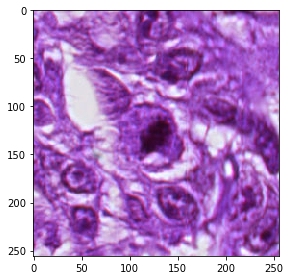

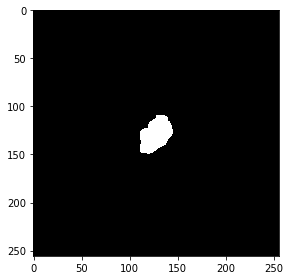

In [17]:
ix = random.randint(0,len(ids))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()

In [11]:
from keras.models import load_model
model = load_model('mitosis_prediction.h5')

In [18]:
inputs = k.layers.Input((img_width,img_height,img_channels))
input_layer = k.layers.Lambda(lambda x: x/255)(inputs)

In [19]:
################## ENCODER / CONTRACTION ###########################

# 2 @ Convolutional Layers with 16 @ (3,3) filters and padding = same
c1 = k.layers.Conv2D(16,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(input_layer)
c1 = k.layers.Dropout(0.1)(c1)
c1 = k.layers.Conv2D(16,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c1)
# Max Pooling with (2,2) filter and stride = 2
p1 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c1)

# 2 @ Convolutional Layers with 32 @ (3,3) filters and padding = same
c2 = k.layers.Conv2D(32,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p1)
c2 = k.layers.Dropout(0.1)(c2)
c2 = k.layers.Conv2D(32,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c2)
# Max Pooling with (2,2) filter and stride = 2
p2 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c2)

# 2 @ Convolutional Layers with 64 @ (3,3) filters and padding = same
c3 = k.layers.Conv2D(64,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p2)
c3 = k.layers.Dropout(0.2)(c3)
c3 = k.layers.Conv2D(64,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c3)
# Max Pooling with (2,2) filter and stride = 2
p3 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c3)

# 2 @ Convolutional Layers with 128 @ (3,3) filters and padding = same
c4 = k.layers.Conv2D(128,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p3)
c4 = k.layers.Dropout(0.2)(c4)
c4 = k.layers.Conv2D(128,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c4)
# Max Pooling with (2,2) filter and stride = 2
p4 = k.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(c4)

# 2 @ Convolutional Layers with 256 @ (3,3) filters and padding = same
c5 = k.layers.Conv2D(256,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(p4)
c5 = k.layers.Dropout(0.3)(c5)
c5 = k.layers.Conv2D(256,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(c5)

################## DECODER / EXPANSION ###########################

# Up-Sampling with 128 @ (3,3) filters and padding = same and stride = 2
u6 = k.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
''' Adding a skip connection, which skip some layer in the neural network and feeds the output of one layer 
    as the input to the next layers (instead of only the next one). skip connections are used to skip features 
    from the contracting path to the expanding path in order to recover spatial information lost during 
    downsampling.'''
u6 = k.layers.concatenate([u6,c4])
# 2 @ Convolutional Layers with 128 @ (3,3) filters and padding = same
c6 = k.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = k.layers.Dropout(0.2)(c6)
c6 = k.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

# Up-Sampling with 64 @ (3,3) filters and padding = same and stride = 2
u7 = k.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = k.layers.concatenate([u7,c3])
# 2 @ Convolutional Layers with 64 @ (3,3) filters and padding = same
c7 = k.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = k.layers.Dropout(0.2)(c7)
c7 = k.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

# Up-Sampling with 32 @ (3,3) filters and padding = same and stride = 2
u8 = k.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = k.layers.concatenate([u8,c2])
# 2 @ Convolutional Layers with 32 @ (3,3) filters and padding = same
c8 = k.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = k.layers.Dropout(0.2)(c8)
c8 = k.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

# Up-Sampling with 16 @ (3,3) filters and padding = same and stride = 2
u9 = k.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = k.layers.concatenate([u9,c1])
# 2 @ Convolutional Layers with 16 @ (3,3) filters and padding = same
c9 = k.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = k.layers.Dropout(0.2)(c9)
c9 = k.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

#Final Output with 1 @ Convolutional Layer and 1 @ (1,1) filter
outputs = k.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model = k.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [20]:
# Model Checkpoint
checkpointer = k.callbacks.ModelCheckpoint('model_mitosis.h5',verbose=1,save_best_only=True)

callbacks = [
        k.callbacks.EarlyStopping(patience=3, monitor='val_loss')]

In [47]:
results = model.fit(x_train,y_train,validation_split = 0.2,batch_size = 20,epochs = 30)

Epoch 1/30
125/125 [==============================] - 1103s 9s/step - loss: 0.0123 - accuracy: 0.9957 - val_loss: 0.0175 - val_accuracy: 0.9934
Epoch 2/30
125/125 [==============================] - 1087s 9s/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.0239 - val_accuracy: 0.9942
Epoch 3/30
125/125 [==============================] - 1111s 9s/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.0245 - val_accuracy: 0.9888
Epoch 4/30
125/125 [==============================] - 1061s 8s/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 0.0089 - val_accuracy: 0.9970
Epoch 5/30
125/125 [==============================] - 1075s 9s/step - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.0090 - val_accuracy: 0.9972
Epoch 6/30
125/125 [==============================] - 1108s 9s/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 0.0115 - val_accuracy: 0.9948
Epoch 7/30
125/125 [==============================] - 1168s 9s/step - loss: 0.0086 - accuracy: 0.9969 - val_loss: 0.0109 - val_accuracy:

In [48]:
model.save('big_model.h5')

In [83]:
pred_train = model.predict(x_train[:int(x_train.shape[0]*0.8)],verbose=1)
pred_val = model.predict(x_train[int(x_train.shape[0]*0.8):],verbose=1)
 
train_predictions = (pred_train > 0.5).astype(np.uint8)
val_predictions = (pred_val > 0.5).astype(np.uint8)

20/20 [==============================] - 71s 3s/step


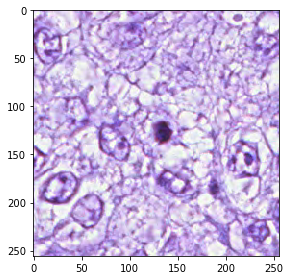

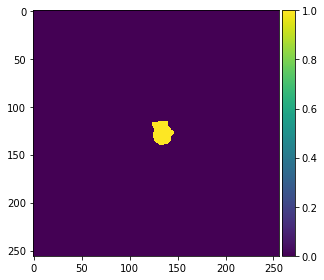

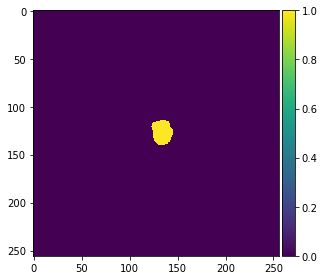

In [87]:
ix = random.randint(0,len(train_predictions))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(train_predictions[ix]))
plt.show()

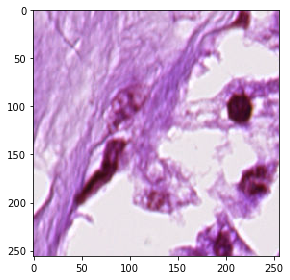

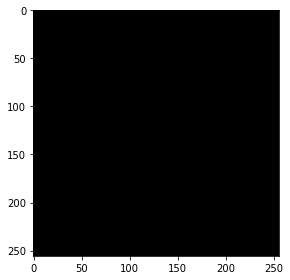

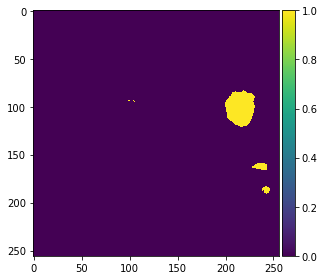

In [96]:
ix = random.randint(0,len(val_predictions))
imshow(x_train[int(x_train.shape[0]*0.8):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.8):][ix]))
plt.show()
imshow(np.squeeze(val_predictions[ix]))
plt.show()

In [94]:
# for i in range(0,len(val_predictions)):
#     imsave('Dataset/prediction/frames/' + str(i) + '.tiff',x_train[int(x_train.shape[0]*0.8):][i])
#     imsave('Dataset/prediction/true/' + str(i) + '.tiff',np.squeeze(y_train[int(y_train.shape[0]*0.8):][i]))
#     imsave('Dataset/prediction/predicted/' + str(i) + '.tiff',np.squeeze(val_predictions[i]))

In [58]:
y_true = np.squeeze(y_train[:int(y_train.shape[0]*0.8)].astype(np.uint8))
pred = np.squeeze(train_predictions)
IoU = k.metrics.MeanIoU(num_classes = 2)
IoU.update_state(y_true,pred)
m_IoU = IoU.result().numpy()*100
print("Mean IoU: %.2f"%m_IoU + ' %')

Mean IoU: 92.60 %


In [97]:
ids = os.listdir(test_path + 'frames')
x_test = np.zeros((len(ids)*16,img_height,img_width,img_channels),dtype=np.uint8)

In [98]:
k = 0
test_ids = []
for n,Id in tqdm(enumerate(ids),total=len(ids)):                            
    img = cv2.imread(test_path + 'frames/'+ Id,1) 
    patches = patchify(img,(256,256,3),step = 256)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            test_ids.append(Id.replace('.tiff','_patch-' + str(i) + str(j) + '.tiff'))
            single_patch = patches[i,j,:,:]
            patch_x = np.squeeze(single_patch,axis=0)
            x_test[k] = patch_x
            k += 1

100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:06<00:00, 27.13it/s]


In [99]:
pred_test = model.predict(x_test,verbose=1)

88/88 [==============================] - 422s 5s/step


In [100]:
test_predictions = (pred_test > 0.5).astype(np.uint8)

In [101]:
test_ids = np.array(test_ids)
test_ids = np.split(test_ids,len(ids))

In [102]:
for i,x in tqdm(enumerate(test_ids), total = len(test_ids)):
    patches = []
    for j,Id in enumerate(x):
        ret, img = cv2.threshold(test_predictions[i*16 + j],0,255,cv2.THRESH_BINARY)
        patches.append(img)
    patches = np.array(patches)
    img =  np.reshape(patches, (4,4,1,256,256,1))
    img = unpatchify(img, (1024,1024,1))
    cv2.imwrite('Dataset/test/predictions/' + x[0].replace('_patch-00',''),img)

100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [00:02<00:00, 86.91it/s]
